Alice original bits
[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1]
Bob Measurments is:
[1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1]
[2, 6, 7, 8, 9, 13, 15, 18, 19, 20, 22, 25, 27, 28, 29, 30]
[1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1]
[1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1]
Alice's sifted key count is:16
Bob's sifted key count is:16
Key exchange was successful.
48-bit derived key: 110110000010010110110010100110011110011010000001
48-bit derived key: 110110000010010110110010100110011110011010000001


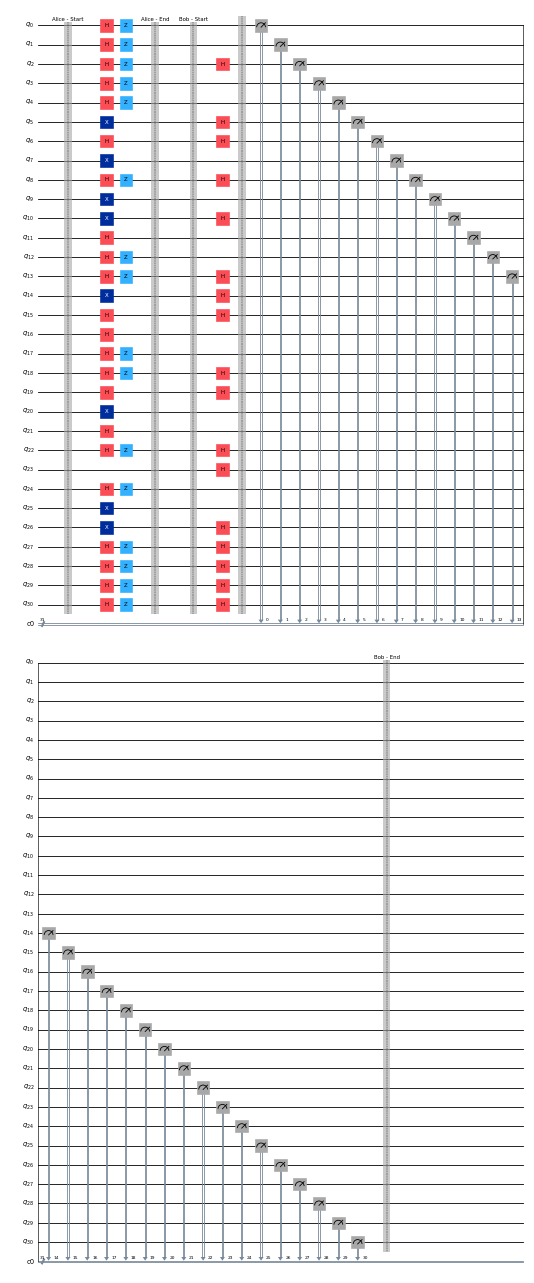

In [1]:
from qiskit import QuantumCircuit
from main import simulate_bb84_without_eve
num_qubits = 31
qc = QuantumCircuit(num_qubits)
simulate_bb84_without_eve(qc, num_qubits)
qc.draw(output='mpl', scale= 0.3)


Alice original bits
[1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1]
Bob Measurments is:
[1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1]
[3, 5, 6, 7, 8, 11, 14, 15, 20, 23, 24, 26, 29, 30]
[0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1]
[1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1]
Alice's sifted key count is:14
Bob's sifted key count is:14
Key exchange failed.


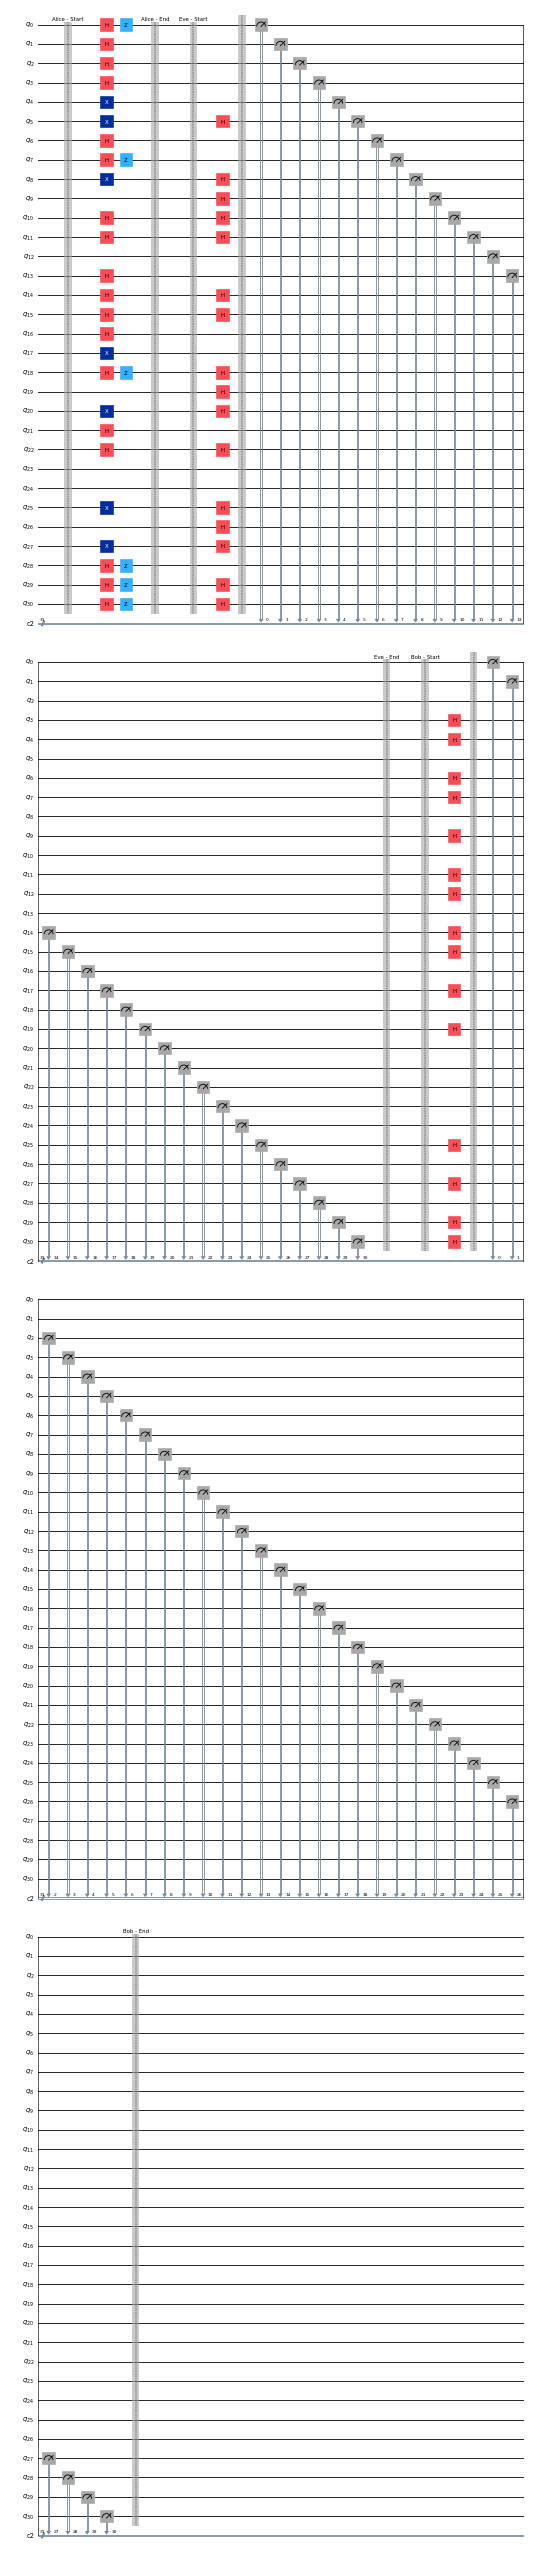

In [2]:
from main import simulate_bb84_with_eve
qc_with_eve = QuantumCircuit(num_qubits)
simulate_bb84_with_eve(qc_with_eve, num_qubits)
qc_with_eve.draw(output='mpl', scale= 0.3)